In [1]:
# Needed on Google Colab
import os
if os.environ.get('COLAB_GPU', False):
    !pip install -U transformers
    from google.colab import drive
    drive.mount("/content/drive")

     |████████████████████████████████| 2.3MB 7.0MB/s 
     |████████████████████████████████| 3.3MB 25.4MB/s 
     |████████████████████████████████| 901kB 48.0MB/s 
Mounted at /content/drive


In [2]:
import nltk
import re
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
from datetime import datetime
from sklearn import metrics
from sklearn.model_selection import train_test_split
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import warnings
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np

pd.options.display.max_colwidth = 6000
pd.options.display.max_rows = 400
np.set_printoptions(suppress=True)
warnings.filterwarnings("ignore")
print(tf.__version__)

2.5.0


In [3]:
# COL_OPINION = 0
# COL_SPEECH = 8
# TOTAL_COLS = 14

# RUNS = 21
# BATCH_SIZE = 16
# TEST_SPLIT = 0.15
# VALIDATION_SPLIT = 0.15
# SHUFFLE = True
# STRATIFY = True
# CLASS_WEIGHTS = True
# REMOVE_STOP_WORDS = False
# STEMMING = False
# LOWERING = False
# NO_PUNCTUATION = False

# OUT_NAME = f'bert_01_{TEST_SPLIT}_{VALIDATION_SPLIT}_Shuff{SHUFFLE}_Strat{STRATIFY}_Weigh{CLASS_WEIGHTS}_NoStop{REMOVE_STOP_WORDS}_Stem{STEMMING}_Low{LOWERING}_NoPun{NO_PUNCTUATION}'
# PATH_METRICS = f'results/{OUT_NAME}.csv'
# PATH_DATASET = "datasets/massnahmen_relevant.csv"
# PATH_PERFORMANCE_GRAPH = f'results/{OUT_NAME}.png'

In [4]:
COL_OPINION = 6
COL_SPEECH = 13
TOTAL_COLS = 14

RUNS = 100
BATCH_SIZE = 16
TEST_SPLIT = 0.15
VALIDATION_SPLIT = 0.0
SHUFFLE = True
STRATIFY = True
CLASS_WEIGHTS = True
REMOVE_STOP_WORDS = False
STEMMING = False
LOWERING = False
NO_PUNCTUATION = False

OUT_NAME = f'lockdown_bert_01_{TEST_SPLIT}_{VALIDATION_SPLIT}_Shuff{SHUFFLE}_Strat{STRATIFY}_Weigh{CLASS_WEIGHTS}_NoStop{REMOVE_STOP_WORDS}_Stem{STEMMING}_Low{LOWERING}_NoPun{NO_PUNCTUATION}'
PATH_METRICS = f'results/{OUT_NAME}.csv'
PATH_DATASET = "datasets/only_lockdown.csv"
PATH_PERFORMANCE_GRAPH = f'results/{OUT_NAME}.png'

Executing this on Colab will make sure that our model runs on a TPU if available and falls back to GPU / CPU otherwise:

In [5]:
# Try to run on TPU if available
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print("Running on TPU ", tpu.cluster_spec().as_dict()["worker"])
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()
print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  ['10.9.101.202:8470']
INFO:tensorflow:Initializing the TPU system: grpc://10.9.101.202:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.9.101.202:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


In [6]:
from os import path

COL_NAMES = ['0.precision', '0.recall', '0.f1-score', '0.support',
             '1.precision', '1.recall', '1.f1-score', '1.support',
             '2.precision', '2.recall', '2.f1-score', '2.support',
             'accuracy',
             'macro avg.precision', 'macro avg.recall', 'macro avg.f1-score', 'macro avg.support',
             'weighted avg.precision', 'weighted avg.recall', 'weighted avg.f1-score', 'weighted avg.support']


def create_file(file_path):
    header = '\t'.join(COL_NAMES) + '\n'

    with open(file_path, 'w+') as f:
        f.write(header)


def dict_to_csv(dict_metrics, file_path):
    # if file does not exist create it and write header
    if not path.exists(file_path):
        create_file(file_path)

    with open(file_path, 'a+') as f:
        values = []
        for col_name in COL_NAMES:
            path_segments = col_name.split('.')
            value = dict_metrics
            for path_segment in path_segments:
                value = value[path_segment]
            values.append(str(value))
        f.write('\t'.join(values) + '\n')

In [7]:
# store current path and download and extract data there
CURR_PATH = !pwd

In [8]:
# PARAMETERS
PATH_DATA = CURR_PATH[0]
PATH_GDRIVE_TMP = "/content/drive/MyDrive/tmp/"  # Google Drive

In [9]:
# read data from csv
data = pd.read_csv(PATH_GDRIVE_TMP + PATH_DATASET, sep='\t', header=None, skiprows=[0])

data["opinion_integer"] = 0
data.loc[data[COL_OPINION] == '-', "opinion_integer"] = 0
data.loc[data[COL_OPINION] == 'o', "opinion_integer"] = 1
data.loc[data[COL_OPINION] == '+', "opinion_integer"] = 2

data.head(6)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,opinion_integer
0,-,x,x,x,-,-,-,29137,2020_03_15,16,NEOS,Abgeordneter Josef Schellhorn (NEOS),False,"Das heißt, diese Planbarkeit ist jetzt gar nicht machbar – für Sie nicht –, nur die Unternehmer kommen mit dieser Unplanbarkeit gar nicht zurecht, weil dieser Lockdown ja jetzt nur für eine Woche bestimmt ist.",0
1,-,x,-,x,x,-,-,31054,2020_03_20,19,NEOS,"Abgeordnete Mag. Beate Meinl-Reisinger, MES (NEOS)",False,"Wie und wann schaffen wir es, aus diesem Lockdown wieder herauszukommen, ohne die Gesundheit der Menschen in Österreich oder auch europaweit aufs Spiel zu setzen?",0
2,-,#,#+,-,x,-,-,32973,2020_04_03,22,ÖVP,Abgeordneter August Wöginger (ÖVP),True,"Kickl hat am 13. März von einem Lockdown gesprochen – also alles zudrehen, nichts geht mehr in diesem Land.",0
3,+,x,+,x,x,+,+,34265,2020_04_03,22,NEOS,Abgeordnete Dipl.-Ing. Karin Doppelbauer (NEOS),False,"Ich möchte gleich zu Beginn eines klarstellen, damit es keine Missverständnisse gibt: Ja, der Lockdown war richtig.",2
4,+,x,x,x,o,o,-,34269,2020_04_03,22,NEOS,Abgeordnete Dipl.-Ing. Karin Doppelbauer (NEOS),False,"Lassen Sie mich aber mit dem Gemeinsamen beginnen: Was das Ziel betrifft, sind wir uns ja alle einig: Es geht um nichts Geringeres als das Einpendeln unserer Volks­wirtschaft auf ein Level, wie es vor der Krise war, oder, wenn Sie so wollen, wenn man jetzt den Lockdown schrittweise lockert, dass dann das Wirtschaftssystem eigentlich genauso aussieht, wie es vor der Krise war.",0
5,+,x,x,x,+s,o,o,34709,2020_04_03,22,NEOS,Abgeordnete Mag. Martina Künsberg Sarre (NEOS),False,"Regelmäßige begleitende Datenerhe­bun­gen in dieser Phase des Lockdowns, in der Lehrer_innen, Schüler_innen und Eltern auf digitales Unterrichten und Lernen absolut angewiesen sind, können einen wesent­lichen Beitrag für eine effiziente Digitalisierung des Bildungssystems in der Zukunft leisten.",1


In [10]:
nltk.download("stopwords")
nltk.download("punkt")
stemmer = SnowballStemmer("german")
stop_words = set(stopwords.words("german"))


def clean_text(text):
    RE_WSPACE = re.compile(r"\s+", re.IGNORECASE)
    RE_TAGS = re.compile(r"<[^>]+>")
    if NO_PUNCTUATION:
        RE_ASCII = re.compile(r"[^A-Za-zÀ-ž ]", re.IGNORECASE)
        RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž]\b", re.IGNORECASE)
    else:
        RE_ASCII = re.compile(r"[^A-Za-zÀ-ž,.!? ]", re.IGNORECASE)
        RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž,.!?]\b", re.IGNORECASE)

    text = re.sub(RE_TAGS, " ", text)
    text = re.sub(RE_ASCII, " ", text)
    text = re.sub(RE_SINGLECHAR, " ", text)
    text = re.sub(RE_WSPACE, " ", text)

    tokenizer = nltk.RegexpTokenizer(r"\w+")
    word_tokens = tokenizer.tokenize(text)
    if LOWERING:
        word_tokens = [word.lower() for word in word_tokens]
    else:
        word_tokens = [word for word in word_tokens]

    if REMOVE_STOP_WORDS:
        word_tokens = [word for word in word_tokens if word not in stop_words]

    if STEMMING:
        word_tokens = [stemmer.stem(word) for word in word_tokens]

    return ' '.join(word_tokens)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [11]:
%%time
# Clean Comments
data["comment_clean"] = data.loc[data[COL_SPEECH].str.len() > 1, COL_SPEECH]
data["comment_clean"] = data["comment_clean"].map(
    lambda x: clean_text(x) if isinstance(x, str) else x
)

CPU times: user 30.4 ms, sys: 5.32 ms, total: 35.8 ms
Wall time: 53.9 ms


In [12]:
# Drop Missing
data = data.dropna(axis="index", subset=["opinion_integer", "comment_clean"]).reset_index(
    drop=True
)
data = data[["comment_clean", "opinion_integer"]]
data.columns = ["text", "label"]

In [13]:
# this will download and initialize the pre trained tokenizer
from transformers import BertTokenizer, TFBertModel

tokenizer = BertTokenizer.from_pretrained("bert-base-german-cased")

In [14]:
speech_lengths = [len(x.split(' ')) for x in data['text'].tolist()]
speech_lengths.sort()

In [15]:
print(speech_lengths[:5])
print(max(speech_lengths))
print(speech_lengths[int(len(speech_lengths)*0.98)])
# With a MAXLEN parameter of 128, we can easily cover 98 per-cent of all speeches in their entirety. Only <2 % need to be trucated.

[4, 4, 5, 5, 6]
109
85


(array([ 63., 136., 140.,  62.,  39.,  22.,  17.,   9.,   2.,   2.]),
 array([  4. ,  14.5,  25. ,  35.5,  46. ,  56.5,  67. ,  77.5,  88. ,
         98.5, 109. ]),
 <a list of 10 Patch objects>)

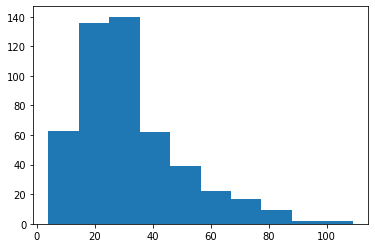

In [16]:
plt.hist(speech_lengths)

In [17]:
MAXLEN = 128

def preprocess_text(data):
    """ take texts and prepare as input features for BERT 
    """
    input_ids = []
    # For every sentence...
    for comment in data:
        encoded_sent = tokenizer.encode_plus(
            text=comment,
            add_special_tokens=True,  # Add `[CLS]` and `[SEP]`
            max_length=MAXLEN,  # Max length to truncate/pad
            pad_to_max_length=True,  # Pad sentence to max length
            return_attention_mask=False,  # attention mask not needed for our task
        )
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get("input_ids"))
    return input_ids

In [18]:
# Original Comment and encoding outputs
comment = ["Bedingt durch die Maßnahmen der ÖVP Grüne Bundesregierung, insbesondere der neuerliche Lockdown im November lassen die Einnahmen ganzer Branchen wegbrechen."]
input_ids = preprocess_text(comment)
print("Comment: ", comment)
print("Tokenized Comment: ", tokenizer.convert_ids_to_tokens(input_ids[0])[0:20])
print("Token IDs: ", input_ids[0][0:20])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Comment:  ['Bedingt durch die Maßnahmen der ÖVP Grüne Bundesregierung, insbesondere der neuerliche Lockdown im November lassen die Einnahmen ganzer Branchen wegbrechen.']
Tokenized Comment:  ['[CLS]', 'Beding', '##t', 'durch', 'die', 'Maßnahmen', 'der', 'ÖVP', 'Grüne', 'Bundesregierung', ',', 'insbesondere', 'der', 'neuer', '##liche', 'Lock', '##down', 'im', 'November', 'lassen']
Token IDs:  [3, 14560, 26901, 261, 30, 3406, 21, 26318, 14134, 4260, 26918, 1831, 21, 4201, 322, 22158, 21646, 106, 1324, 1641]


In [19]:
%%time
import pickle

input_ids = preprocess_text(data["text"])
# tokenization takes quite long
# we can save the result and load it quickly via pickle
#pickle.dump(input_ids, open(PATH_GDRIVE_TMP + "input_ids_lockdown.pkl", "wb"))
# input_ids = pickle.load(open(PATH_GDRIVE_TMP+"/input_ids.pkl", "rb"))

CPU times: user 430 ms, sys: 798 µs, total: 431 ms
Wall time: 425 ms


# Here Begins the Repeatable Code

In [20]:
# Set Model Parameters
MAXLEN = MAXLEN
BATCH_SIZE_PER_REPLICA = 8
BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync
EPOCHS = 20
LEARNING_RATE = 1e-5
DATA_LENGTH = len(data)

In [21]:
# Stop training when validation acc starts dropping
# Save checkpoint of model each period
now = datetime.now().strftime("%Y-%m-%d_%H%M")
# Create callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", verbose=1, patience=5, restore_best_weights=True
    ),
    # tf.keras.callbacks.ModelCheckpoint(
    #    PATH_GDRIVE_TMP + now + "_Model_{epoch:02d}_{val_loss:.4f}.h5",
    #    monitor="val_loss",
    #    save_best_only=True,
    #    verbose=1,
    # ),
]

In [22]:
def build_model(transformer, max_len=MAXLEN):
    """ add binary classification to pretrained model
    """
    input_word_ids = tf.keras.layers.Input(
        shape=(max_len,), dtype=tf.int32, name="input_word_ids"
    )
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = tf.keras.layers.Dense(3, activation="sigmoid")(cls_token)
    model = tf.keras.models.Model(inputs=input_word_ids, outputs=out)
    model.compile(
        tf.keras.optimizers.Adam(lr=LEARNING_RATE),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [23]:
def create_dataset(
    data_tuple,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    buffer_size=DATA_LENGTH,
    train=False,
):
    dataset = tf.data.Dataset.from_tensor_slices(data_tuple)
    if train:
        dataset = dataset.shuffle(
            buffer_size=buffer_size, reshuffle_each_iteration=True
        ).repeat(epochs)
    dataset = dataset.batch(batch_size)
    return dataset

In [24]:
from collections import Counter

In [25]:
runs = 22
accuracies = []
for i in range(runs):
  if STRATIFY:
    train_ids_, test_ids, train_labels_, test_labels = train_test_split(input_ids, data["label"], test_size=TEST_SPLIT, shuffle=SHUFFLE, stratify=data["label"])
  else:
    train_ids_, test_ids, train_labels_, test_labels = train_test_split(input_ids, data["label"], test_size=TEST_SPLIT, shuffle=SHUFFLE)
  
  if VALIDATION_SPLIT > 0:
    train_ids, valid_ids, train_labels, valid_labels = train_test_split(train_ids_, train_labels_, test_size=VALIDATION_SPLIT, shuffle=SHUFFLE, stratify=train_labels_)
    train = create_dataset((train_ids, train_labels), buffer_size=len(train_ids), train=True)
    validation = create_dataset((valid_ids, valid_labels), buffer_size=len(valid_ids), train=True)
  else:
    train = create_dataset((train_ids_, train_labels_), buffer_size=len(train_ids_), train=True)
    validation = create_dataset((train_ids_, train_labels_), buffer_size=len(train_ids_), train=True)
    train_labels = train_labels_
    train_ids = train_ids_

  test = create_dataset((test_ids, test_labels), buffer_size=len(test_ids))
  
  with strategy.scope():
    transformer_layers = TFBertModel.from_pretrained("bert-base-german-cased")
    model = build_model(transformer_layers, max_len=MAXLEN)
  train_counts = Counter(train_labels)
  num_in_largest_class = max(train_counts.values())
  class_weights = {k: num_in_largest_class / train_counts[k] for k in train_counts.keys()}

  # Train using appropriate steps per epochs (go through all train data in an epoch)
  steps_per_epoch = int(np.floor((len(train_ids) / BATCH_SIZE)))
  hist = model.fit(
    train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation,
    verbose=1,
    class_weight = class_weights if CLASS_WEIGHTS else None,
    callbacks=callbacks,
  )

  # Evaluate
  pred = model.predict(test, batch_size=BATCH_SIZE, verbose=2, use_multiprocessing=True)
  pred_class = np.argmax(pred, axis=-1)
  report = metrics.classification_report(test_labels, pred_class, output_dict=True)
  dict_to_csv(report, PATH_GDRIVE_TMP + PATH_METRICS)
  acc = report['accuracy']
  accuracies.append(acc)

Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


Epoch 1/20


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None,) dtype=float32>]


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None,) dtype=float32>]


6/6 [==============================] - ETA: 0s - loss: 2.5111 - accuracy: 0.3229

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


6/6 [==============================] - 91s 3s/step - loss: 2.5111 - accuracy: 0.3229 - val_loss: 1.6156 - val_accuracy: 0.2608
Epoch 2/20
6/6 [==============================] - 4s 786ms/step - loss: 2.0374 - accuracy: 0.3047 - val_loss: 1.0418 - val_accuracy: 0.5598
Epoch 3/20
6/6 [==============================] - 4s 779ms/step - loss: 2.0231 - accuracy: 0.3281 - val_loss: 1.2151 - val_accuracy: 0.2895
Epoch 4/20
6/6 [==============================] - 4s 777ms/step - loss: 1.8384 - accuracy: 0.3411 - val_loss: 0.9864 - val_accuracy: 0.5694
Epoch 5/20
6/6 [==============================] - 4s 783ms/step - loss: 1.8777 - accuracy: 0.3828 - val_loss: 1.0866 - val_accuracy: 0.3900
Epoch 6/20
6/6 [==============================] - 4s 869ms/step - loss: 1.8208 - accuracy: 0.3932 - val_loss: 0.9886 - val_accuracy: 0.5024
Epoch 7/20
6/6 [==============================] - 4s 789ms/step - loss: 1.6555 - accuracy: 0.5026 - val_loss: 0.9031 - val_accuracy: 0.5981
Epoch 8/20
6/6 [=================

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


2/2 - 13s


Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None,) dtype=float32>]


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None,) dtype=float32>]


6/6 [==============================] - ETA: 0s - loss: 2.3037 - accuracy: 0.3464

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


6/6 [==============================] - 95s 3s/step - loss: 2.3037 - accuracy: 0.3464 - val_loss: 1.2145 - val_accuracy: 0.2823
Epoch 2/20
6/6 [==============================] - 4s 781ms/step - loss: 1.9974 - accuracy: 0.3958 - val_loss: 1.0305 - val_accuracy: 0.4545
Epoch 3/20
6/6 [==============================] - 4s 794ms/step - loss: 1.8899 - accuracy: 0.2891 - val_loss: 0.9952 - val_accuracy: 0.5837
Epoch 4/20
6/6 [==============================] - 4s 799ms/step - loss: 1.7830 - accuracy: 0.4661 - val_loss: 1.0130 - val_accuracy: 0.4928
Epoch 5/20
6/6 [==============================] - 4s 790ms/step - loss: 1.7355 - accuracy: 0.4219 - val_loss: 0.9803 - val_accuracy: 0.5407
Epoch 6/20
6/6 [==============================] - 4s 793ms/step - loss: 1.6019 - accuracy: 0.5365 - val_loss: 0.9188 - val_accuracy: 0.6077
Epoch 7/20
6/6 [==============================] - 4s 798ms/step - loss: 1.6812 - accuracy: 0.5052 - val_loss: 0.9027 - val_accuracy: 0.5789
Epoch 8/20
6/6 [=================

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


2/2 - 13s


Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None,) dtype=float32>]


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None,) dtype=float32>]


6/6 [==============================] - ETA: 0s - loss: 1.9975 - accuracy: 0.3464

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


6/6 [==============================] - 96s 4s/step - loss: 1.9975 - accuracy: 0.3464 - val_loss: 1.3659 - val_accuracy: 0.1890
Epoch 2/20
6/6 [==============================] - 4s 784ms/step - loss: 1.9923 - accuracy: 0.3620 - val_loss: 1.2325 - val_accuracy: 0.2416
Epoch 3/20
6/6 [==============================] - 4s 790ms/step - loss: 1.7872 - accuracy: 0.3542 - val_loss: 1.1257 - val_accuracy: 0.2895
Epoch 4/20
6/6 [==============================] - 4s 794ms/step - loss: 1.8677 - accuracy: 0.3594 - val_loss: 1.1916 - val_accuracy: 0.2464
Epoch 5/20
6/6 [==============================] - 4s 792ms/step - loss: 1.8991 - accuracy: 0.3359 - val_loss: 1.1434 - val_accuracy: 0.2632
Epoch 6/20
6/6 [==============================] - 4s 789ms/step - loss: 1.7607 - accuracy: 0.4375 - val_loss: 1.1497 - val_accuracy: 0.2057
Epoch 7/20
6/6 [==============================] - 4s 786ms/step - loss: 1.7710 - accuracy: 0.3776 - val_loss: 1.0039 - val_accuracy: 0.4737
Epoch 8/20
6/6 [=================

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


2/2 - 12s


Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None,) dtype=float32>]


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None,) dtype=float32>]


6/6 [==============================] - ETA: 0s - loss: 2.2275 - accuracy: 0.3047

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


6/6 [==============================] - 95s 3s/step - loss: 2.2275 - accuracy: 0.3047 - val_loss: 1.3062 - val_accuracy: 0.1914
Epoch 2/20
6/6 [==============================] - 4s 782ms/step - loss: 1.9656 - accuracy: 0.3672 - val_loss: 1.0348 - val_accuracy: 0.4067
Epoch 3/20
6/6 [==============================] - 5s 911ms/step - loss: 1.8110 - accuracy: 0.4427 - val_loss: 1.1755 - val_accuracy: 0.3062
Epoch 4/20
6/6 [==============================] - 4s 788ms/step - loss: 1.7790 - accuracy: 0.3438 - val_loss: 0.9854 - val_accuracy: 0.5072
Epoch 5/20
6/6 [==============================] - 4s 797ms/step - loss: 1.6961 - accuracy: 0.5339 - val_loss: 0.9375 - val_accuracy: 0.5478
Epoch 6/20
6/6 [==============================] - 4s 789ms/step - loss: 1.6733 - accuracy: 0.4271 - val_loss: 0.9375 - val_accuracy: 0.5526
Epoch 7/20
6/6 [==============================] - 4s 799ms/step - loss: 1.5876 - accuracy: 0.5833 - val_loss: 0.8866 - val_accuracy: 0.6100
Epoch 8/20
6/6 [=================

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


2/2 - 13s


Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None,) dtype=float32>]


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None,) dtype=float32>]


6/6 [==============================] - ETA: 0s - loss: 2.0494 - accuracy: 0.3073

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


6/6 [==============================] - 98s 3s/step - loss: 2.0494 - accuracy: 0.3073 - val_loss: 0.9735 - val_accuracy: 0.5646
Epoch 2/20
6/6 [==============================] - 4s 791ms/step - loss: 1.8726 - accuracy: 0.3906 - val_loss: 1.2804 - val_accuracy: 0.1962
Epoch 3/20
6/6 [==============================] - 4s 791ms/step - loss: 1.9381 - accuracy: 0.4089 - val_loss: 1.0205 - val_accuracy: 0.4641
Epoch 4/20
6/6 [==============================] - 4s 794ms/step - loss: 1.8554 - accuracy: 0.4089 - val_loss: 1.0297 - val_accuracy: 0.4426
Epoch 5/20
6/6 [==============================] - 4s 795ms/step - loss: 1.7672 - accuracy: 0.3880 - val_loss: 0.9094 - val_accuracy: 0.6148
Epoch 6/20
6/6 [==============================] - 4s 786ms/step - loss: 1.6444 - accuracy: 0.6172 - val_loss: 0.9002 - val_accuracy: 0.6220
Epoch 7/20
6/6 [==============================] - 4s 791ms/step - loss: 1.5367 - accuracy: 0.5130 - val_loss: 0.7923 - val_accuracy: 0.6555
Epoch 8/20
6/6 [=================

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


2/2 - 13s


Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None,) dtype=float32>]


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None,) dtype=float32>]


6/6 [==============================] - ETA: 0s - loss: 2.1722 - accuracy: 0.3750

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


6/6 [==============================] - 97s 3s/step - loss: 2.1722 - accuracy: 0.3750 - val_loss: 1.5533 - val_accuracy: 0.1818
Epoch 2/20
6/6 [==============================] - 4s 784ms/step - loss: 1.9928 - accuracy: 0.3255 - val_loss: 0.9905 - val_accuracy: 0.5694
Epoch 3/20
6/6 [==============================] - 4s 780ms/step - loss: 1.8798 - accuracy: 0.3828 - val_loss: 1.1714 - val_accuracy: 0.2440
Epoch 4/20
6/6 [==============================] - 4s 779ms/step - loss: 1.8775 - accuracy: 0.3333 - val_loss: 1.0240 - val_accuracy: 0.4306
Epoch 5/20
6/6 [==============================] - 4s 776ms/step - loss: 1.6843 - accuracy: 0.5026 - val_loss: 0.9598 - val_accuracy: 0.5861
Epoch 6/20
6/6 [==============================] - 4s 776ms/step - loss: 1.8126 - accuracy: 0.3828 - val_loss: 1.0662 - val_accuracy: 0.4067
Epoch 7/20
6/6 [==============================] - 4s 785ms/step - loss: 1.6839 - accuracy: 0.5495 - val_loss: 0.8362 - val_accuracy: 0.6555
Epoch 8/20
6/6 [=================

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


2/2 - 13s


Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None,) dtype=float32>]


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None,) dtype=float32>]


6/6 [==============================] - ETA: 0s - loss: 2.4277 - accuracy: 0.3177

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


6/6 [==============================] - 98s 3s/step - loss: 2.4277 - accuracy: 0.3177 - val_loss: 1.4091 - val_accuracy: 0.2560
Epoch 2/20
6/6 [==============================] - 4s 783ms/step - loss: 2.1129 - accuracy: 0.2839 - val_loss: 1.3459 - val_accuracy: 0.2560
Epoch 3/20
6/6 [==============================] - 4s 782ms/step - loss: 1.9285 - accuracy: 0.3802 - val_loss: 1.1615 - val_accuracy: 0.2847
Epoch 4/20
6/6 [==============================] - 4s 784ms/step - loss: 1.8879 - accuracy: 0.2891 - val_loss: 1.2833 - val_accuracy: 0.2871
Epoch 5/20
6/6 [==============================] - 4s 784ms/step - loss: 1.8938 - accuracy: 0.3828 - val_loss: 1.1946 - val_accuracy: 0.2321
Epoch 6/20
6/6 [==============================] - 4s 786ms/step - loss: 1.8725 - accuracy: 0.2839 - val_loss: 1.1803 - val_accuracy: 0.2919
Epoch 7/20
6/6 [==============================] - 4s 797ms/step - loss: 1.8517 - accuracy: 0.4349 - val_loss: 1.1064 - val_accuracy: 0.2943
Epoch 8/20
6/6 [=================

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


2/2 - 13s


Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None,) dtype=float32>]


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None,) dtype=float32>]


6/6 [==============================] - ETA: 0s - loss: 2.2897 - accuracy: 0.3411

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


6/6 [==============================] - 98s 3s/step - loss: 2.2897 - accuracy: 0.3411 - val_loss: 1.0916 - val_accuracy: 0.3014
Epoch 2/20
6/6 [==============================] - 5s 905ms/step - loss: 1.8902 - accuracy: 0.3464 - val_loss: 1.0419 - val_accuracy: 0.5096
Epoch 3/20
6/6 [==============================] - 4s 782ms/step - loss: 1.8102 - accuracy: 0.4245 - val_loss: 1.0245 - val_accuracy: 0.4593
Epoch 4/20
6/6 [==============================] - 4s 791ms/step - loss: 1.8169 - accuracy: 0.4010 - val_loss: 1.0337 - val_accuracy: 0.4617
Epoch 5/20
6/6 [==============================] - 4s 793ms/step - loss: 1.7394 - accuracy: 0.4245 - val_loss: 0.9360 - val_accuracy: 0.5813
Epoch 6/20
6/6 [==============================] - 4s 791ms/step - loss: 1.7187 - accuracy: 0.4661 - val_loss: 0.9320 - val_accuracy: 0.5885
Epoch 7/20
6/6 [==============================] - 4s 792ms/step - loss: 1.6413 - accuracy: 0.5078 - val_loss: 0.8039 - val_accuracy: 0.7033
Epoch 8/20
6/6 [=================

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


2/2 - 13s


Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None,) dtype=float32>]


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None,) dtype=float32>]


6/6 [==============================] - ETA: 0s - loss: 2.2557 - accuracy: 0.3203

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


6/6 [==============================] - 95s 3s/step - loss: 2.2557 - accuracy: 0.3203 - val_loss: 1.1592 - val_accuracy: 0.2584
Epoch 2/20
6/6 [==============================] - 5s 922ms/step - loss: 2.0020 - accuracy: 0.3646 - val_loss: 1.1130 - val_accuracy: 0.2153
Epoch 3/20
6/6 [==============================] - 4s 787ms/step - loss: 1.8826 - accuracy: 0.3073 - val_loss: 1.0338 - val_accuracy: 0.5359
Epoch 4/20
6/6 [==============================] - 4s 786ms/step - loss: 1.8191 - accuracy: 0.4401 - val_loss: 1.0333 - val_accuracy: 0.5000
Epoch 5/20
6/6 [==============================] - 4s 789ms/step - loss: 1.8033 - accuracy: 0.3724 - val_loss: 1.0026 - val_accuracy: 0.5526
Epoch 6/20
6/6 [==============================] - 4s 786ms/step - loss: 1.7562 - accuracy: 0.3802 - val_loss: 0.9684 - val_accuracy: 0.5622
Epoch 7/20
6/6 [==============================] - 4s 783ms/step - loss: 1.7381 - accuracy: 0.4583 - val_loss: 0.9660 - val_accuracy: 0.5622
Epoch 8/20
6/6 [=================

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


2/2 - 13s


Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None,) dtype=float32>]


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None,) dtype=float32>]


6/6 [==============================] - ETA: 0s - loss: 2.4860 - accuracy: 0.3151

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


6/6 [==============================] - 96s 3s/step - loss: 2.4860 - accuracy: 0.3151 - val_loss: 0.9763 - val_accuracy: 0.5622
Epoch 2/20
6/6 [==============================] - 4s 780ms/step - loss: 1.9744 - accuracy: 0.4115 - val_loss: 1.3132 - val_accuracy: 0.1866
Epoch 3/20
6/6 [==============================] - 4s 781ms/step - loss: 1.9546 - accuracy: 0.2734 - val_loss: 1.0337 - val_accuracy: 0.3947
Epoch 4/20
6/6 [==============================] - 4s 798ms/step - loss: 1.9267 - accuracy: 0.2682 - val_loss: 1.1277 - val_accuracy: 0.2536
Epoch 5/20
6/6 [==============================] - 5s 924ms/step - loss: 1.8755 - accuracy: 0.3438 - val_loss: 1.0249 - val_accuracy: 0.4904
Epoch 6/20
6/6 [==============================] - 4s 786ms/step - loss: 1.8211 - accuracy: 0.3385 - val_loss: 1.0787 - val_accuracy: 0.2943
Restoring model weights from the end of the best epoch.
Epoch 00006: early stopping


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


2/2 - 13s


Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None,) dtype=float32>]


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None,) dtype=float32>]


6/6 [==============================] - ETA: 0s - loss: 2.4938 - accuracy: 0.3151

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


6/6 [==============================] - 97s 3s/step - loss: 2.4938 - accuracy: 0.3151 - val_loss: 1.3280 - val_accuracy: 0.2703
Epoch 2/20
6/6 [==============================] - 4s 775ms/step - loss: 2.0103 - accuracy: 0.3255 - val_loss: 0.9571 - val_accuracy: 0.5598
Epoch 3/20
6/6 [==============================] - 4s 783ms/step - loss: 1.8035 - accuracy: 0.4323 - val_loss: 1.1155 - val_accuracy: 0.3086
Epoch 4/20
6/6 [==============================] - 4s 792ms/step - loss: 1.7663 - accuracy: 0.4062 - val_loss: 0.9187 - val_accuracy: 0.5981
Epoch 5/20
6/6 [==============================] - 5s 924ms/step - loss: 1.7163 - accuracy: 0.5938 - val_loss: 1.1053 - val_accuracy: 0.3708
Epoch 6/20
6/6 [==============================] - 4s 786ms/step - loss: 1.6637 - accuracy: 0.4453 - val_loss: 0.8087 - val_accuracy: 0.6986
Epoch 7/20
6/6 [==============================] - 4s 793ms/step - loss: 1.5062 - accuracy: 0.6328 - val_loss: 0.7635 - val_accuracy: 0.7297
Epoch 8/20
6/6 [=================

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


2/2 - 13s


Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None,) dtype=float32>]


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None,) dtype=float32>]


6/6 [==============================] - ETA: 0s - loss: 2.3701 - accuracy: 0.3568

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


6/6 [==============================] - 98s 4s/step - loss: 2.3701 - accuracy: 0.3568 - val_loss: 1.4710 - val_accuracy: 0.1842
Epoch 2/20
6/6 [==============================] - 4s 781ms/step - loss: 1.8726 - accuracy: 0.3099 - val_loss: 1.1249 - val_accuracy: 0.3565
Epoch 3/20
6/6 [==============================] - 4s 790ms/step - loss: 1.8095 - accuracy: 0.3698 - val_loss: 0.9594 - val_accuracy: 0.5622
Epoch 4/20
6/6 [==============================] - 4s 785ms/step - loss: 1.7237 - accuracy: 0.5104 - val_loss: 0.9627 - val_accuracy: 0.5455
Epoch 5/20
6/6 [==============================] - 4s 788ms/step - loss: 1.7471 - accuracy: 0.4323 - val_loss: 1.0156 - val_accuracy: 0.4426
Epoch 6/20
6/6 [==============================] - 4s 788ms/step - loss: 1.5819 - accuracy: 0.5599 - val_loss: 0.7874 - val_accuracy: 0.6938
Epoch 7/20
6/6 [==============================] - 4s 788ms/step - loss: 1.5632 - accuracy: 0.4974 - val_loss: 0.8205 - val_accuracy: 0.6411
Epoch 8/20
6/6 [=================

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


2/2 - 13s


Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None,) dtype=float32>]


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None,) dtype=float32>]


6/6 [==============================] - ETA: 0s - loss: 2.2701 - accuracy: 0.3047

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


6/6 [==============================] - 99s 3s/step - loss: 2.2701 - accuracy: 0.3047 - val_loss: 1.1663 - val_accuracy: 0.2584
Epoch 2/20
6/6 [==============================] - 4s 784ms/step - loss: 1.8386 - accuracy: 0.4036 - val_loss: 0.9141 - val_accuracy: 0.5742
Epoch 3/20
6/6 [==============================] - 4s 790ms/step - loss: 1.8167 - accuracy: 0.4870 - val_loss: 1.0307 - val_accuracy: 0.4258
Epoch 4/20
6/6 [==============================] - 4s 786ms/step - loss: 1.6383 - accuracy: 0.4661 - val_loss: 0.7767 - val_accuracy: 0.6866
Epoch 5/20
6/6 [==============================] - 4s 792ms/step - loss: 1.5181 - accuracy: 0.6120 - val_loss: 0.7826 - val_accuracy: 0.6818
Epoch 6/20
6/6 [==============================] - 4s 789ms/step - loss: 1.4183 - accuracy: 0.6432 - val_loss: 0.7385 - val_accuracy: 0.7033
Epoch 7/20
6/6 [==============================] - 4s 793ms/step - loss: 1.2506 - accuracy: 0.7005 - val_loss: 0.5360 - val_accuracy: 0.8254
Epoch 8/20
6/6 [=================

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


2/2 - 15s


Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None,) dtype=float32>]


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None,) dtype=float32>]


6/6 [==============================] - ETA: 0s - loss: 2.4374 - accuracy: 0.3359

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


6/6 [==============================] - 98s 4s/step - loss: 2.4374 - accuracy: 0.3359 - val_loss: 1.5271 - val_accuracy: 0.2584
Epoch 2/20
6/6 [==============================] - 4s 790ms/step - loss: 2.1103 - accuracy: 0.2240 - val_loss: 1.0095 - val_accuracy: 0.5622
Epoch 3/20
6/6 [==============================] - 4s 791ms/step - loss: 2.0120 - accuracy: 0.4219 - val_loss: 1.2313 - val_accuracy: 0.3038
Epoch 4/20
6/6 [==============================] - 4s 799ms/step - loss: 1.8595 - accuracy: 0.3281 - val_loss: 1.0787 - val_accuracy: 0.2990
Epoch 5/20
6/6 [==============================] - 4s 797ms/step - loss: 1.7139 - accuracy: 0.4792 - val_loss: 1.0636 - val_accuracy: 0.3732
Epoch 6/20
6/6 [==============================] - 4s 793ms/step - loss: 1.8220 - accuracy: 0.4010 - val_loss: 1.1039 - val_accuracy: 0.2799
Epoch 7/20
6/6 [==============================] - 4s 791ms/step - loss: 1.7926 - accuracy: 0.3672 - val_loss: 1.0045 - val_accuracy: 0.4593
Epoch 8/20
6/6 [=================

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


2/2 - 13s


Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None,) dtype=float32>]


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None,) dtype=float32>]


6/6 [==============================] - ETA: 0s - loss: 2.2042 - accuracy: 0.3542

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


6/6 [==============================] - 99s 3s/step - loss: 2.2042 - accuracy: 0.3542 - val_loss: 1.0878 - val_accuracy: 0.5120
Epoch 2/20
6/6 [==============================] - 4s 786ms/step - loss: 1.9607 - accuracy: 0.4401 - val_loss: 1.1677 - val_accuracy: 0.3469
Epoch 3/20
6/6 [==============================] - 4s 788ms/step - loss: 1.8737 - accuracy: 0.3464 - val_loss: 0.9318 - val_accuracy: 0.6029
Epoch 4/20
6/6 [==============================] - 4s 795ms/step - loss: 1.7738 - accuracy: 0.4844 - val_loss: 1.0017 - val_accuracy: 0.5120
Epoch 5/20
6/6 [==============================] - 4s 806ms/step - loss: 1.6701 - accuracy: 0.5156 - val_loss: 0.8585 - val_accuracy: 0.6531
Epoch 6/20
6/6 [==============================] - 4s 800ms/step - loss: 1.5688 - accuracy: 0.5807 - val_loss: 0.8597 - val_accuracy: 0.6388
Epoch 7/20
6/6 [==============================] - 4s 792ms/step - loss: 1.4329 - accuracy: 0.6120 - val_loss: 0.7088 - val_accuracy: 0.7321
Epoch 8/20
6/6 [=================

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


2/2 - 13s


Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None,) dtype=float32>]


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None,) dtype=float32>]


6/6 [==============================] - ETA: 0s - loss: 2.1567 - accuracy: 0.3828

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


6/6 [==============================] - 98s 4s/step - loss: 2.1567 - accuracy: 0.3828 - val_loss: 1.2426 - val_accuracy: 0.2799
Epoch 2/20
6/6 [==============================] - 4s 782ms/step - loss: 2.0370 - accuracy: 0.3958 - val_loss: 1.0730 - val_accuracy: 0.3062
Epoch 3/20
6/6 [==============================] - 4s 789ms/step - loss: 1.9862 - accuracy: 0.2943 - val_loss: 1.1941 - val_accuracy: 0.2464
Epoch 4/20
6/6 [==============================] - 4s 784ms/step - loss: 1.8816 - accuracy: 0.4688 - val_loss: 0.9754 - val_accuracy: 0.5622
Epoch 5/20
6/6 [==============================] - 4s 784ms/step - loss: 1.8294 - accuracy: 0.3802 - val_loss: 1.1865 - val_accuracy: 0.2847
Epoch 6/20
6/6 [==============================] - 4s 778ms/step - loss: 1.7763 - accuracy: 0.3906 - val_loss: 0.9167 - val_accuracy: 0.6148
Epoch 7/20
6/6 [==============================] - 4s 780ms/step - loss: 1.6592 - accuracy: 0.5130 - val_loss: 0.9799 - val_accuracy: 0.4665
Epoch 8/20
6/6 [=================

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


2/2 - 13s


Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None,) dtype=float32>]


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None,) dtype=float32>]


6/6 [==============================] - ETA: 0s - loss: 2.2067 - accuracy: 0.3594

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


6/6 [==============================] - 99s 3s/step - loss: 2.2067 - accuracy: 0.3594 - val_loss: 1.1276 - val_accuracy: 0.2943
Epoch 2/20
6/6 [==============================] - 4s 777ms/step - loss: 1.9383 - accuracy: 0.3203 - val_loss: 1.3220 - val_accuracy: 0.2368
Epoch 3/20
6/6 [==============================] - 4s 782ms/step - loss: 1.8845 - accuracy: 0.3984 - val_loss: 0.9599 - val_accuracy: 0.5526
Epoch 4/20
6/6 [==============================] - 5s 928ms/step - loss: 1.7819 - accuracy: 0.4219 - val_loss: 1.1583 - val_accuracy: 0.2847
Epoch 5/20
6/6 [==============================] - 4s 780ms/step - loss: 1.7985 - accuracy: 0.3932 - val_loss: 0.9430 - val_accuracy: 0.5622
Epoch 6/20
6/6 [==============================] - 4s 784ms/step - loss: 1.6613 - accuracy: 0.4766 - val_loss: 1.0225 - val_accuracy: 0.4258
Epoch 7/20
6/6 [==============================] - 4s 791ms/step - loss: 1.7025 - accuracy: 0.4557 - val_loss: 0.8769 - val_accuracy: 0.6244
Epoch 8/20
6/6 [=================

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


2/2 - 13s


Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None,) dtype=float32>]


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None,) dtype=float32>]


6/6 [==============================] - ETA: 0s - loss: 2.2087 - accuracy: 0.2995

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


6/6 [==============================] - 98s 3s/step - loss: 2.2087 - accuracy: 0.2995 - val_loss: 1.0060 - val_accuracy: 0.5311
Epoch 2/20
6/6 [==============================] - 4s 776ms/step - loss: 1.8738 - accuracy: 0.3464 - val_loss: 1.0442 - val_accuracy: 0.4904
Epoch 3/20
6/6 [==============================] - 4s 790ms/step - loss: 1.7931 - accuracy: 0.4089 - val_loss: 1.0034 - val_accuracy: 0.5215
Epoch 4/20
6/6 [==============================] - 4s 791ms/step - loss: 1.8948 - accuracy: 0.3151 - val_loss: 1.0847 - val_accuracy: 0.3421
Epoch 5/20
6/6 [==============================] - 4s 788ms/step - loss: 1.8157 - accuracy: 0.4036 - val_loss: 1.1472 - val_accuracy: 0.2632
Epoch 6/20
6/6 [==============================] - 4s 789ms/step - loss: 1.8073 - accuracy: 0.3750 - val_loss: 1.0413 - val_accuracy: 0.4282
Epoch 7/20
6/6 [==============================] - 4s 789ms/step - loss: 1.7751 - accuracy: 0.5000 - val_loss: 1.0998 - val_accuracy: 0.3373
Epoch 8/20
6/6 [=================

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


2/2 - 13s


Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None,) dtype=float32>]


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None,) dtype=float32>]


6/6 [==============================] - ETA: 0s - loss: 2.1395 - accuracy: 0.3307

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


6/6 [==============================] - 100s 4s/step - loss: 2.1395 - accuracy: 0.3307 - val_loss: 1.1746 - val_accuracy: 0.2943
Epoch 2/20
6/6 [==============================] - 4s 782ms/step - loss: 1.8789 - accuracy: 0.3854 - val_loss: 1.0341 - val_accuracy: 0.5526
Epoch 3/20
6/6 [==============================] - 4s 785ms/step - loss: 1.7618 - accuracy: 0.3776 - val_loss: 1.0027 - val_accuracy: 0.4665
Epoch 4/20
6/6 [==============================] - 4s 794ms/step - loss: 1.7380 - accuracy: 0.4349 - val_loss: 0.9893 - val_accuracy: 0.4928
Epoch 5/20
6/6 [==============================] - 4s 792ms/step - loss: 1.6744 - accuracy: 0.4818 - val_loss: 0.8778 - val_accuracy: 0.6220
Epoch 6/20
6/6 [==============================] - 4s 800ms/step - loss: 1.5777 - accuracy: 0.5443 - val_loss: 0.8149 - val_accuracy: 0.6699
Epoch 7/20
6/6 [==============================] - 4s 789ms/step - loss: 1.4903 - accuracy: 0.5990 - val_loss: 0.7917 - val_accuracy: 0.6627
Epoch 8/20
6/6 [================

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


2/2 - 15s


Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None,) dtype=float32>]


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None,) dtype=float32>]


6/6 [==============================] - ETA: 0s - loss: 2.0411 - accuracy: 0.4349

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


6/6 [==============================] - 98s 4s/step - loss: 2.0411 - accuracy: 0.4349 - val_loss: 1.2457 - val_accuracy: 0.2847
Epoch 2/20
6/6 [==============================] - 4s 785ms/step - loss: 1.9547 - accuracy: 0.2786 - val_loss: 0.9863 - val_accuracy: 0.5670
Epoch 3/20
6/6 [==============================] - 4s 796ms/step - loss: 1.8982 - accuracy: 0.4297 - val_loss: 1.1760 - val_accuracy: 0.3421
Epoch 4/20
6/6 [==============================] - 4s 791ms/step - loss: 1.8304 - accuracy: 0.3828 - val_loss: 0.9108 - val_accuracy: 0.6388
Epoch 5/20
6/6 [==============================] - 4s 802ms/step - loss: 1.7069 - accuracy: 0.5156 - val_loss: 1.0316 - val_accuracy: 0.4474
Epoch 6/20
6/6 [==============================] - 4s 806ms/step - loss: 1.6183 - accuracy: 0.5182 - val_loss: 0.8129 - val_accuracy: 0.7010
Epoch 7/20
6/6 [==============================] - 4s 795ms/step - loss: 1.5784 - accuracy: 0.5964 - val_loss: 0.9727 - val_accuracy: 0.5096
Epoch 8/20
6/6 [=================

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


2/2 - 13s


Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None,) dtype=float32>]


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None,) dtype=float32>]


6/6 [==============================] - ETA: 0s - loss: 2.2276 - accuracy: 0.3828

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


6/6 [==============================] - 99s 4s/step - loss: 2.2276 - accuracy: 0.3828 - val_loss: 1.0397 - val_accuracy: 0.4856
Epoch 2/20
6/6 [==============================] - 4s 793ms/step - loss: 1.8633 - accuracy: 0.3672 - val_loss: 1.0630 - val_accuracy: 0.3708
Epoch 3/20
6/6 [==============================] - 5s 947ms/step - loss: 1.8462 - accuracy: 0.3906 - val_loss: 1.0312 - val_accuracy: 0.4187
Epoch 4/20
6/6 [==============================] - 4s 797ms/step - loss: 1.8080 - accuracy: 0.4635 - val_loss: 1.0594 - val_accuracy: 0.4115
Epoch 5/20
6/6 [==============================] - 4s 791ms/step - loss: 1.7069 - accuracy: 0.4271 - val_loss: 0.8811 - val_accuracy: 0.5981
Epoch 6/20
6/6 [==============================] - 4s 791ms/step - loss: 1.6887 - accuracy: 0.4922 - val_loss: 0.9704 - val_accuracy: 0.5048
Epoch 7/20
6/6 [==============================] - 4s 797ms/step - loss: 1.6171 - accuracy: 0.5495 - val_loss: 0.8456 - val_accuracy: 0.5957
Epoch 8/20
6/6 [=================

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


2/2 - 13s


Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None,) dtype=float32>]


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None,) dtype=float32>]


6/6 [==============================] - ETA: 0s - loss: 2.3794 - accuracy: 0.3385

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


6/6 [==============================] - 97s 3s/step - loss: 2.3794 - accuracy: 0.3385 - val_loss: 1.2786 - val_accuracy: 0.2656
Epoch 2/20
6/6 [==============================] - 4s 777ms/step - loss: 1.9031 - accuracy: 0.3646 - val_loss: 0.9850 - val_accuracy: 0.5526
Epoch 3/20
6/6 [==============================] - 4s 790ms/step - loss: 1.9698 - accuracy: 0.3125 - val_loss: 1.1567 - val_accuracy: 0.2440
Epoch 4/20
6/6 [==============================] - 4s 802ms/step - loss: 1.7802 - accuracy: 0.3828 - val_loss: 0.9352 - val_accuracy: 0.5909
Epoch 5/20
6/6 [==============================] - 5s 921ms/step - loss: 1.8146 - accuracy: 0.4844 - val_loss: 1.0669 - val_accuracy: 0.4067
Epoch 6/20
6/6 [==============================] - 4s 780ms/step - loss: 1.6882 - accuracy: 0.4661 - val_loss: 0.8445 - val_accuracy: 0.6148
Epoch 7/20
6/6 [==============================] - 4s 790ms/step - loss: 1.5847 - accuracy: 0.5938 - val_loss: 0.8712 - val_accuracy: 0.6077
Epoch 8/20
6/6 [=================

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


2/2 - 13s


# New Section

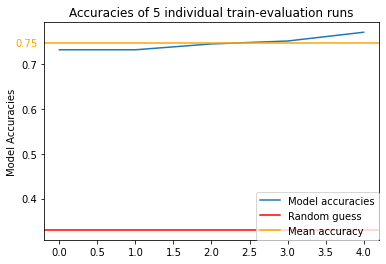

In [ ]:
total = len(accuracies)
mean = sum(accuracies)/total

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(sorted(accuracies), label='Model accuracies')
plt.axhline(y=0.33, color='r', linestyle='-', label='Random guess')
plt.axhline(y=mean, color='orange', linestyle='-', label='Mean accuracy')
ax.text(-0.02, mean, "{:.2f}".format(mean), color='orange', ha="right", va="center", 
        transform=ax.get_yaxis_transform())
plt.ylabel('Model Accuracies')
plt.title(f"Accuracies of {total} individual train-evaluation runs")
plt.legend(loc="lower right", borderaxespad=0)
plt.savefig(PATH_GDRIVE_TMP + PATH_PERFORMANCE_GRAPH)
plt.show()